# 7. Zmiany po oddaniu milestone_1.

a) ustaliliśmy, że kolumna Time zostanie usunięta, ponieważ nie mamy wystarczająco informacji na jej temat \
b) wykresy, które zostały zrobione na całym zbiorze danych należy zrobić **tylko** na zbiorze treningowym \
c) ustaliśmy, że nie będziemy stosować techniki SMOTE i nie będziemy robić nic z liczbą danych


In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
# Wczytywanie danych i bibliotek
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

filepath = "C:/Users/Wojtek/Documents/ML/projekt_1/data/creditcard_csv.csv"

df = pd.read_csv(filepath)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [8]:
# cechy zabieramy
X = df.drop('Class', axis=1)
y = df['Class'].replace({"'0'": 0, "'1'": 1})

# dzielimy
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# print("Kolumny w X_train_valid:", X_train_valid.columns.tolist())
# print("Rozmiar X_train_valid:", X_train_valid.shape)
# print("Rozmiar y_train_valid:", y_train_valid.shape)

## Punkt pierwszy z pliku do milestone 2 czyli "Inżynieria cech"

1. 	Tworzenie nowych zmiennych na podstawie dostępnych danych
2. 	Selekcja cech – usunięcie zmiennych o niskiej wartości informacyjnej oraz redukcja wymiarowości.
3. 	Eksperymenty z transformacjami zmiennych (np. logarytmowanie, skalowanie, pierwiastkowanie). 


**I teraz co ja uważam - jeżeli chodzi o tworzenie nowych zmiennych to absolutnie nie mam na to pomysłu, ponieważ z Amount nic nie zrobimy, nie wiem jak podejść do tego pod wzgledem V1- V28 od strony matematycznej**

ad.2 selekcja cech - usuwamy Time

ad.3 - poniżej jest kilka wykresów, moim zdaniem ten ze spierwiastkowanymi danymi jest najciekawszy ewentualnie ten z niezmienionymi, po zlogarytmowaniu te gęstości są tak naprawde bardzo podobne więc się nie opłaca tego brać.**

C:\Users\Wojtek\Documents\ML\klasyfikacja\.venv1\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)



### Rozkład bez zmian ###


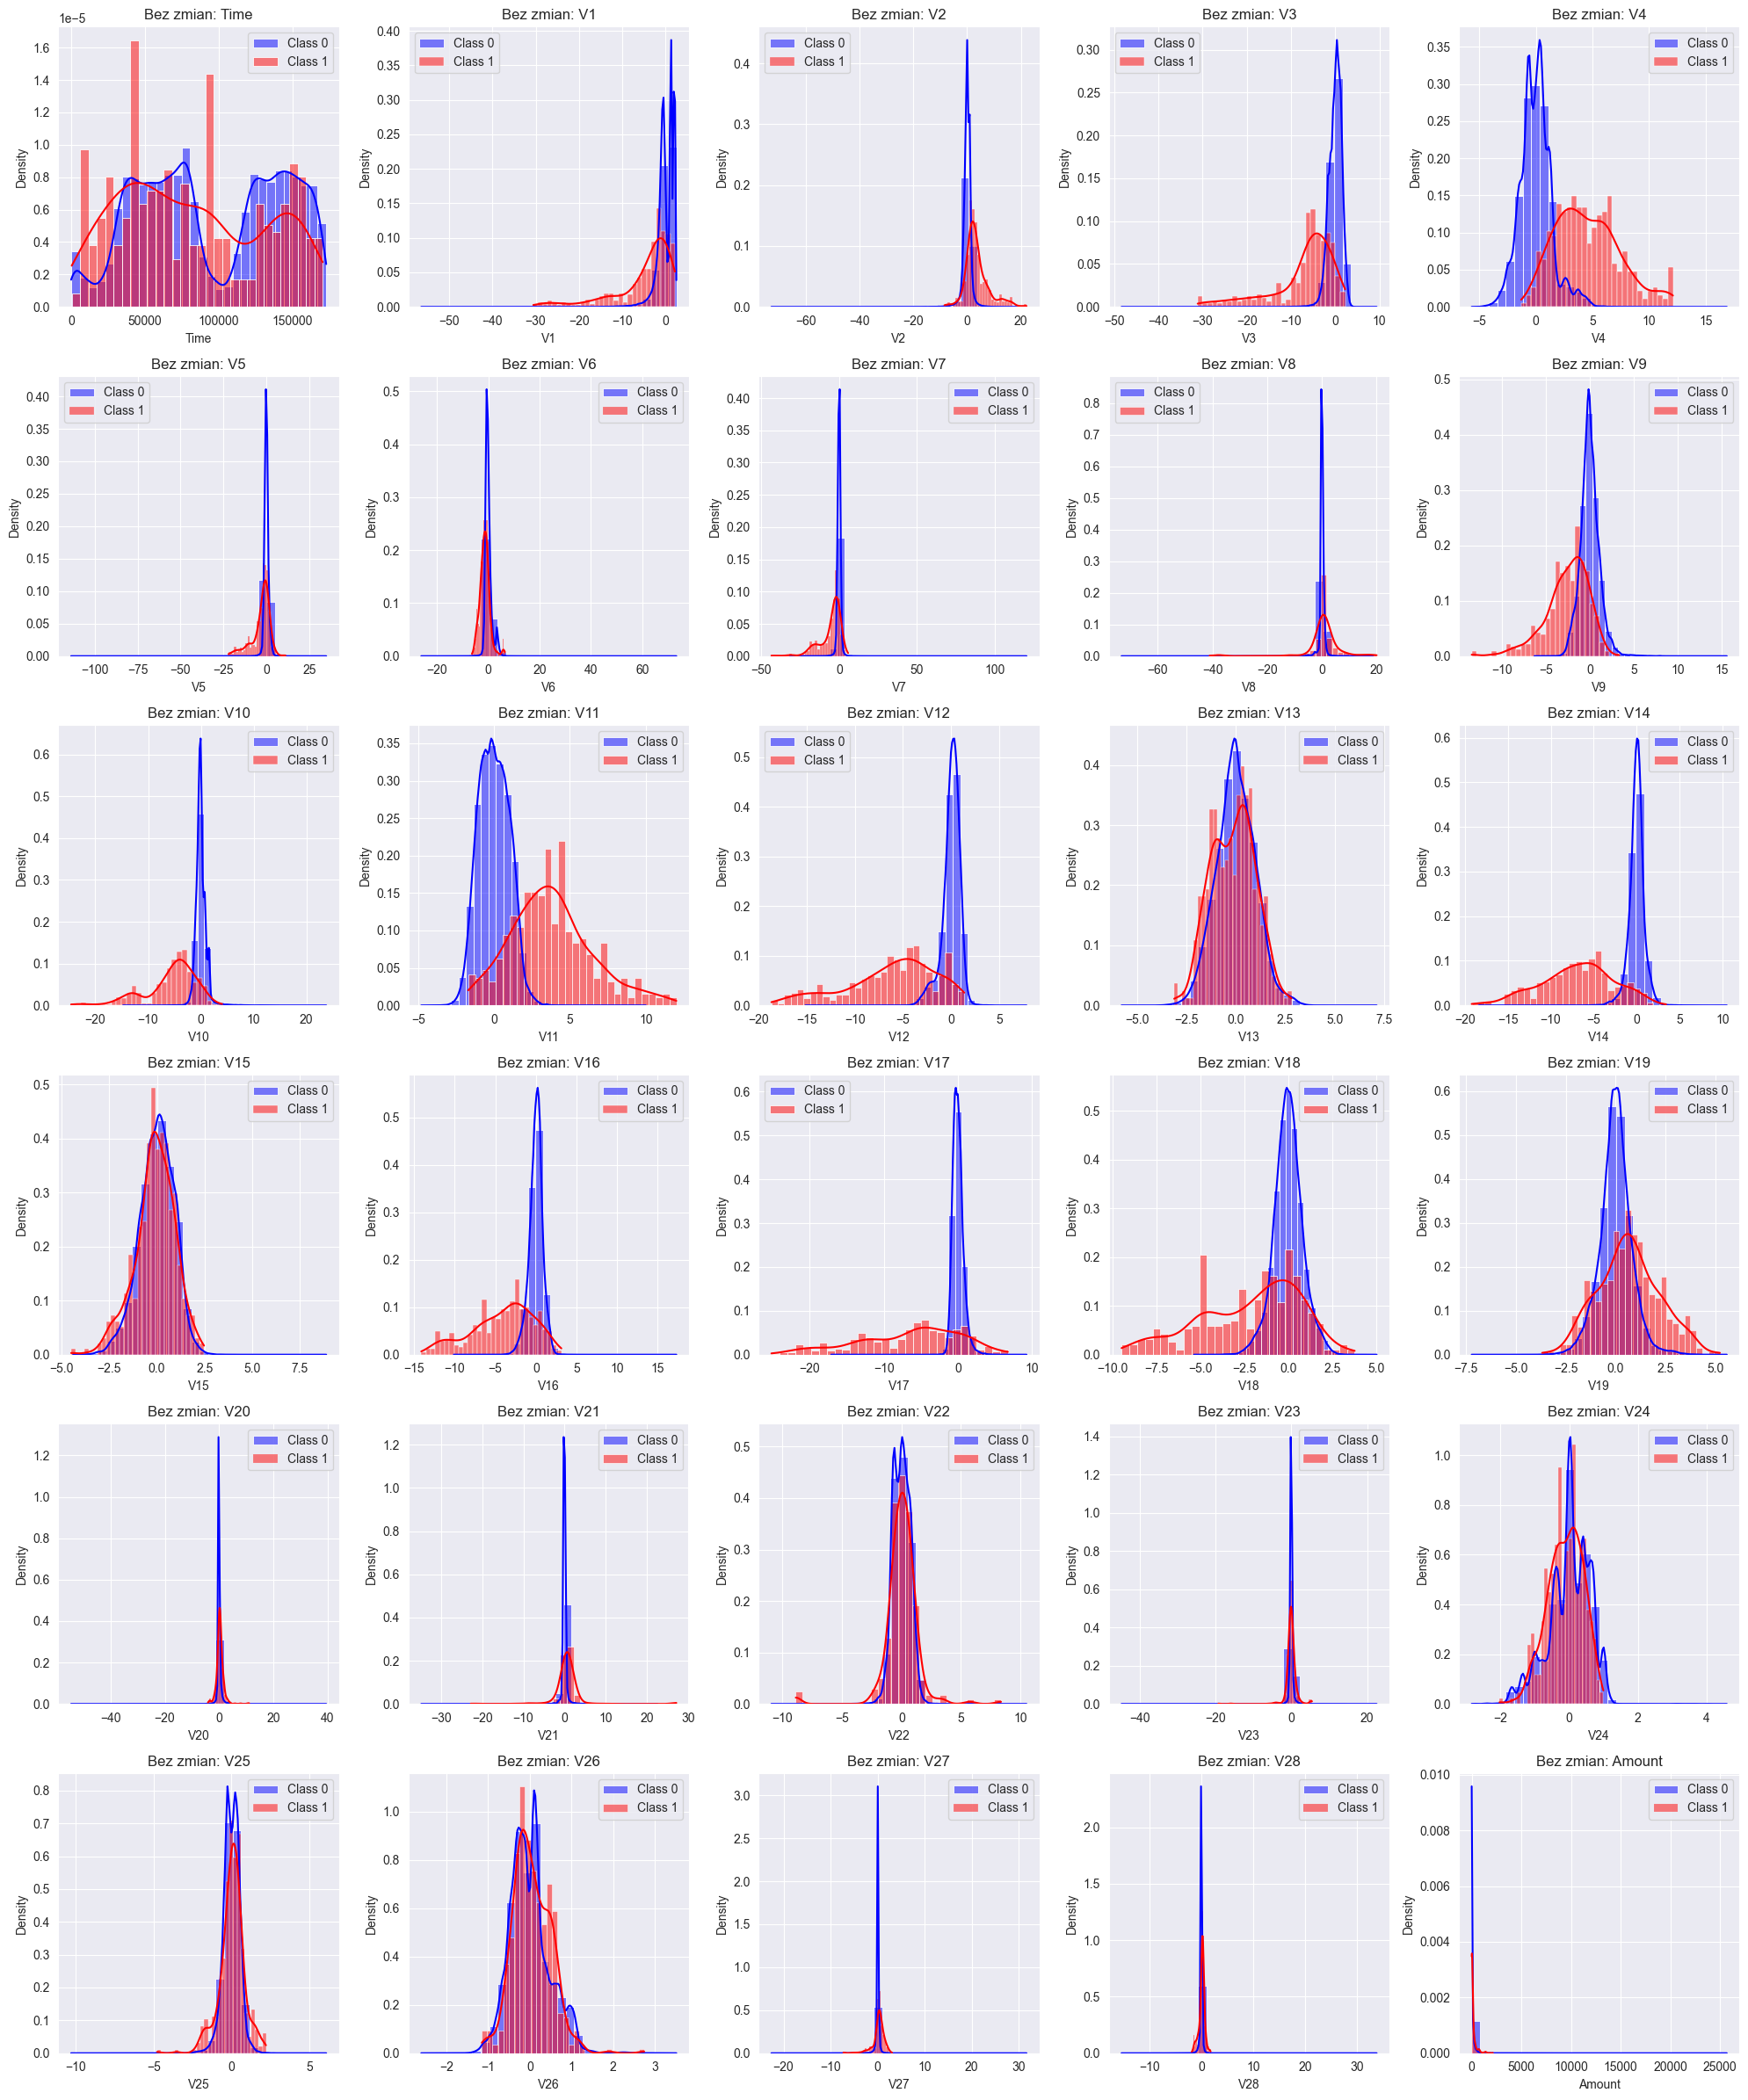


### Rozkład po logarytmowaniu1p ###


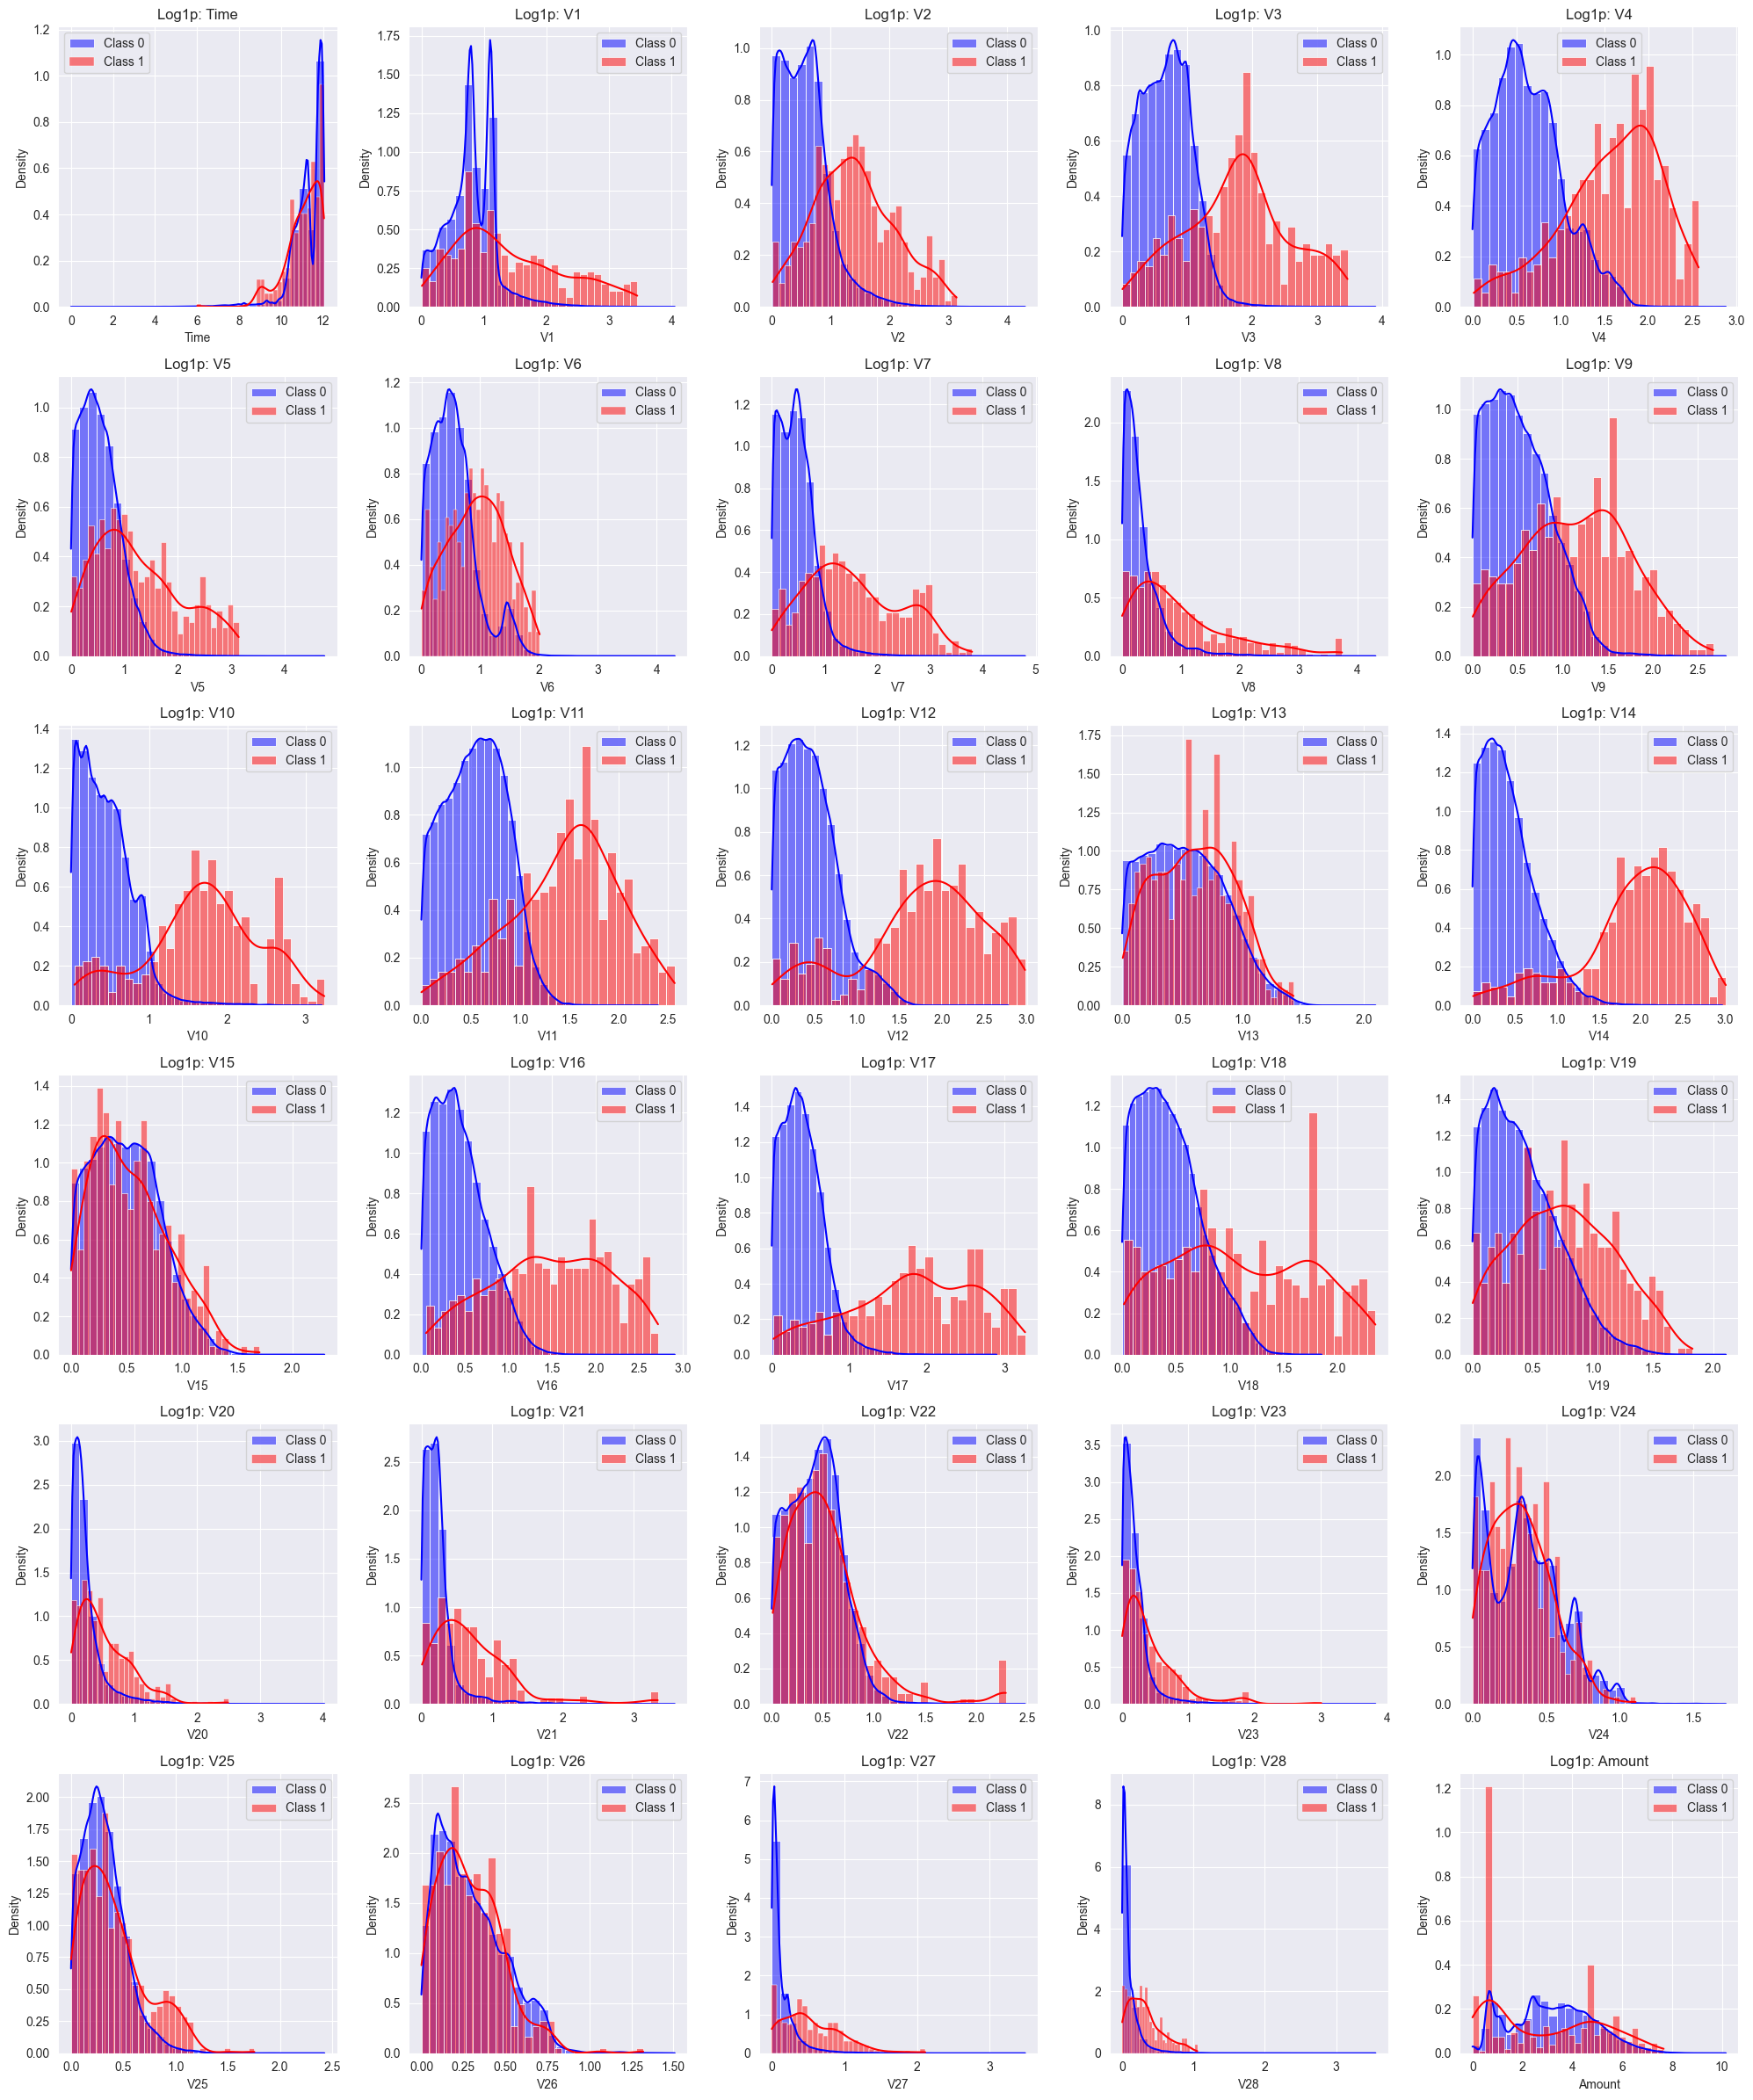


### Rozkład po pierwiastkowaniu ###


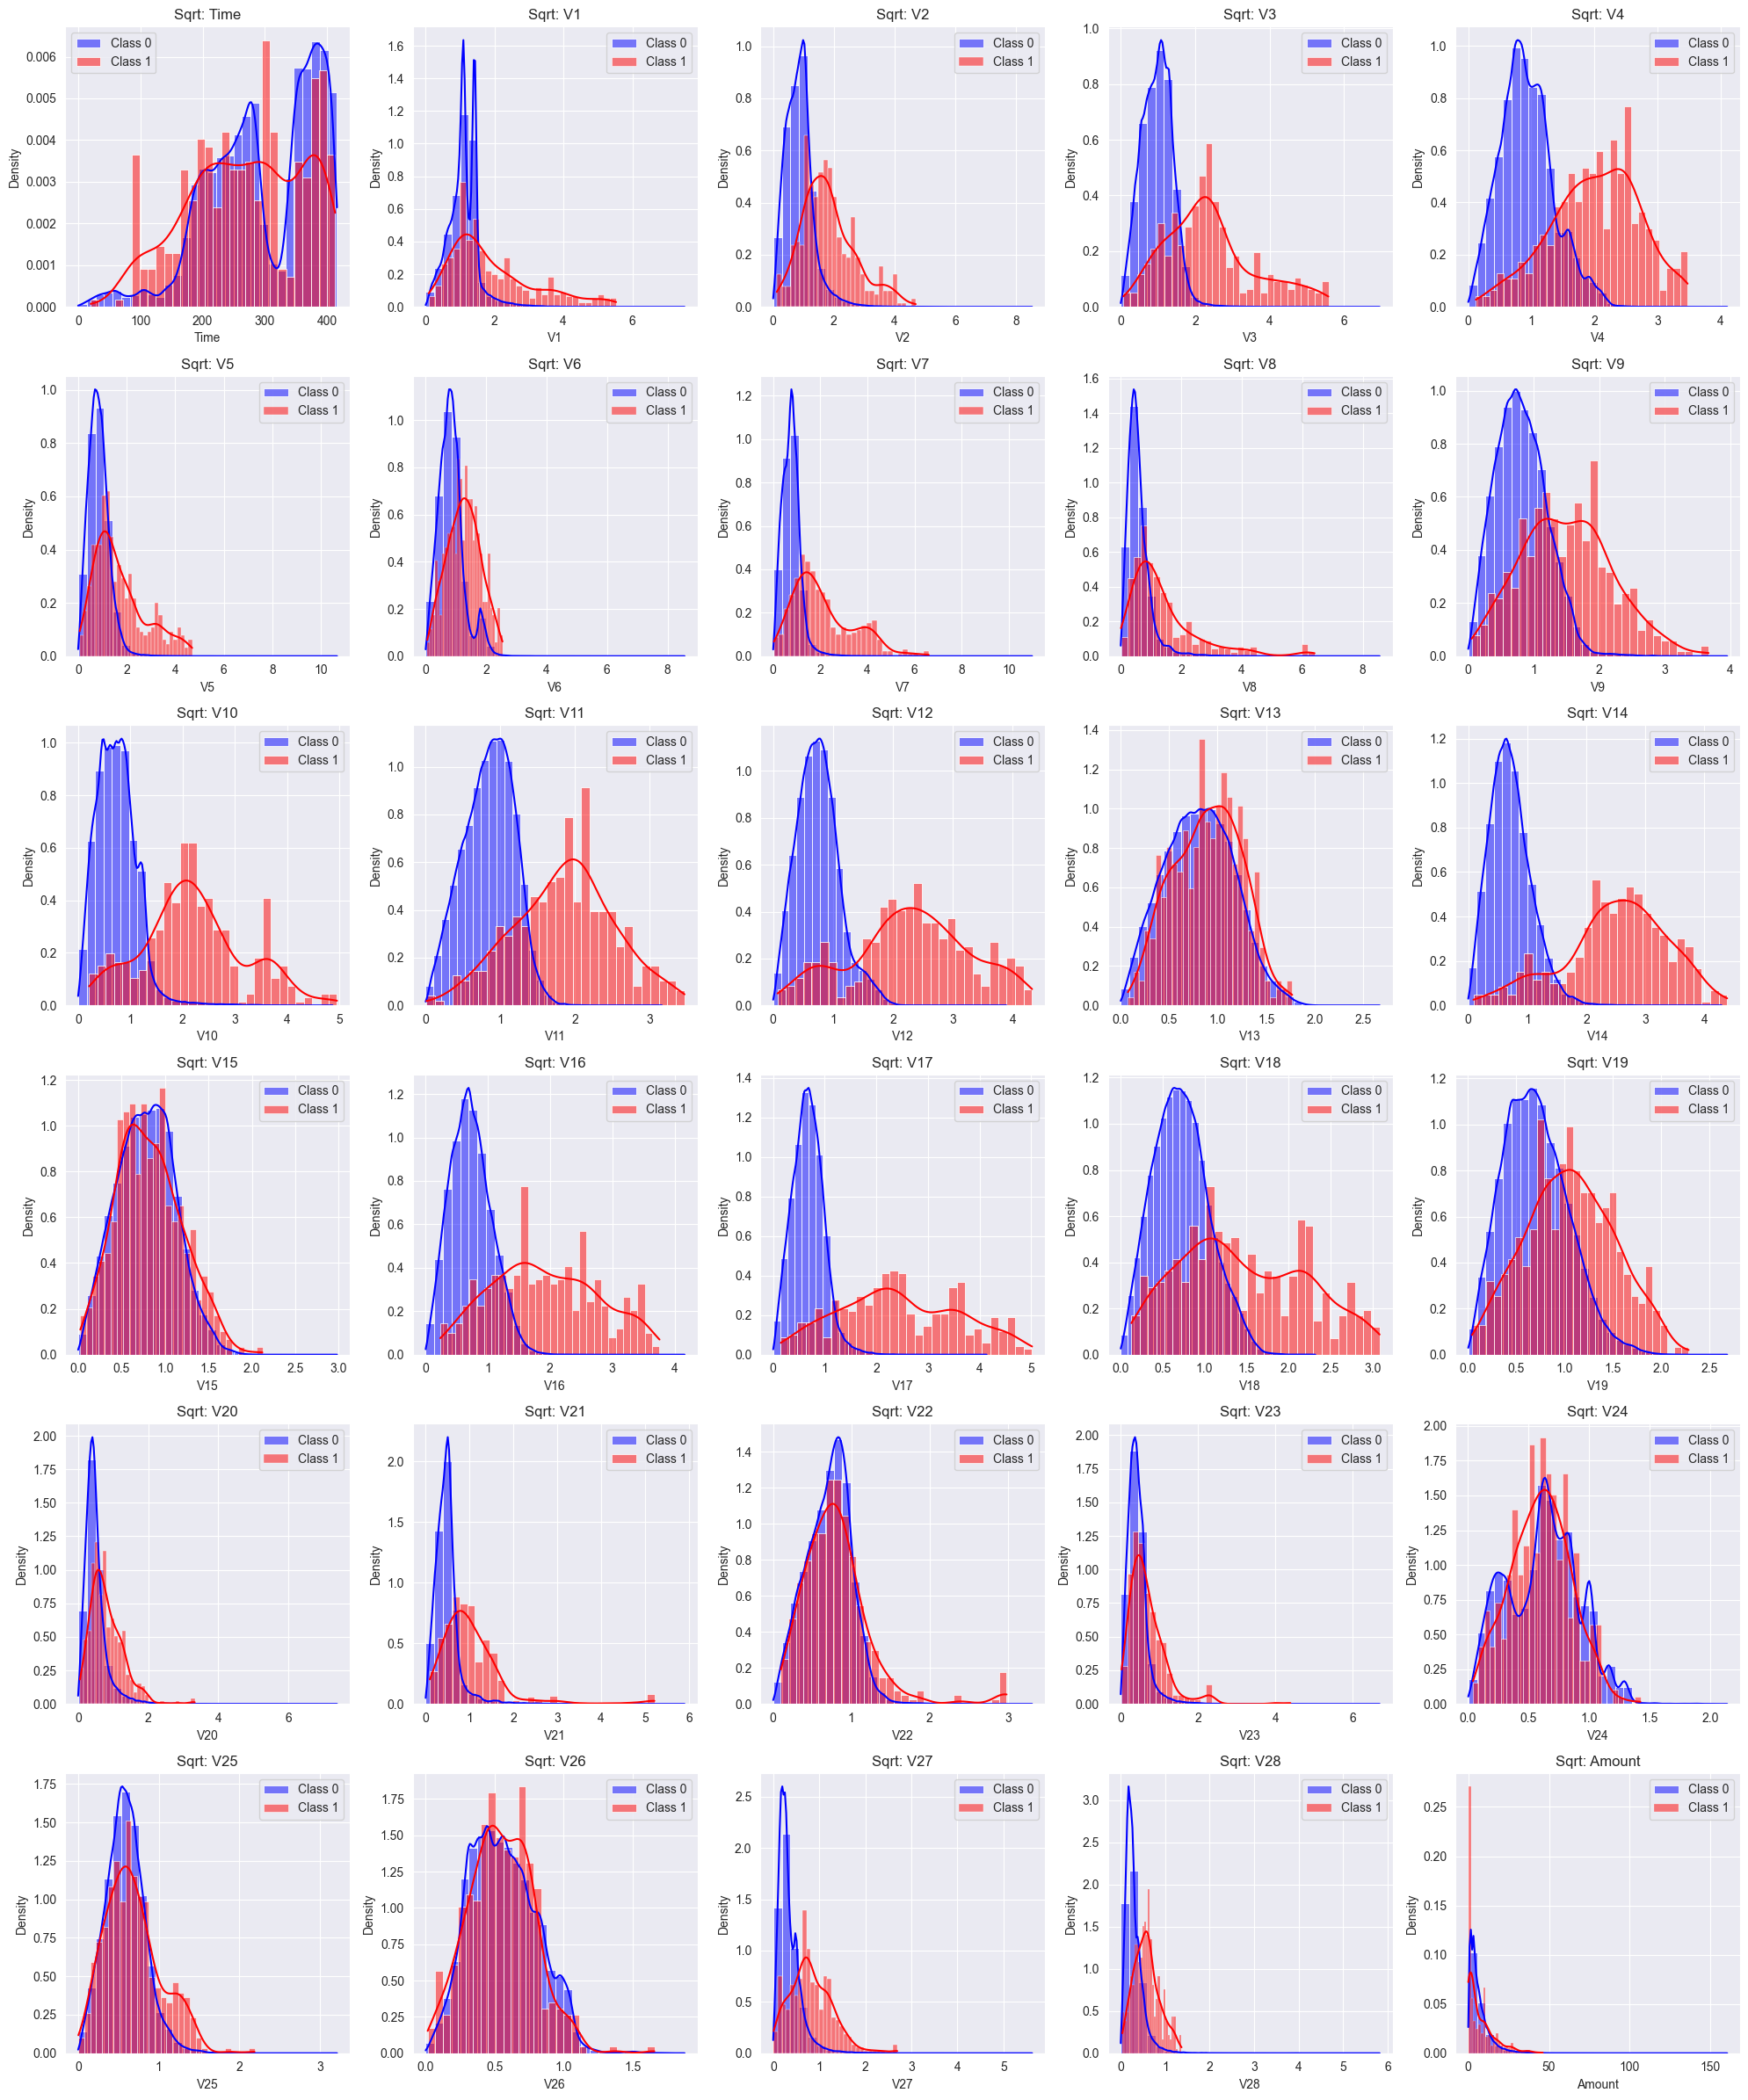


### Rozkład po logarytmowaniu ###


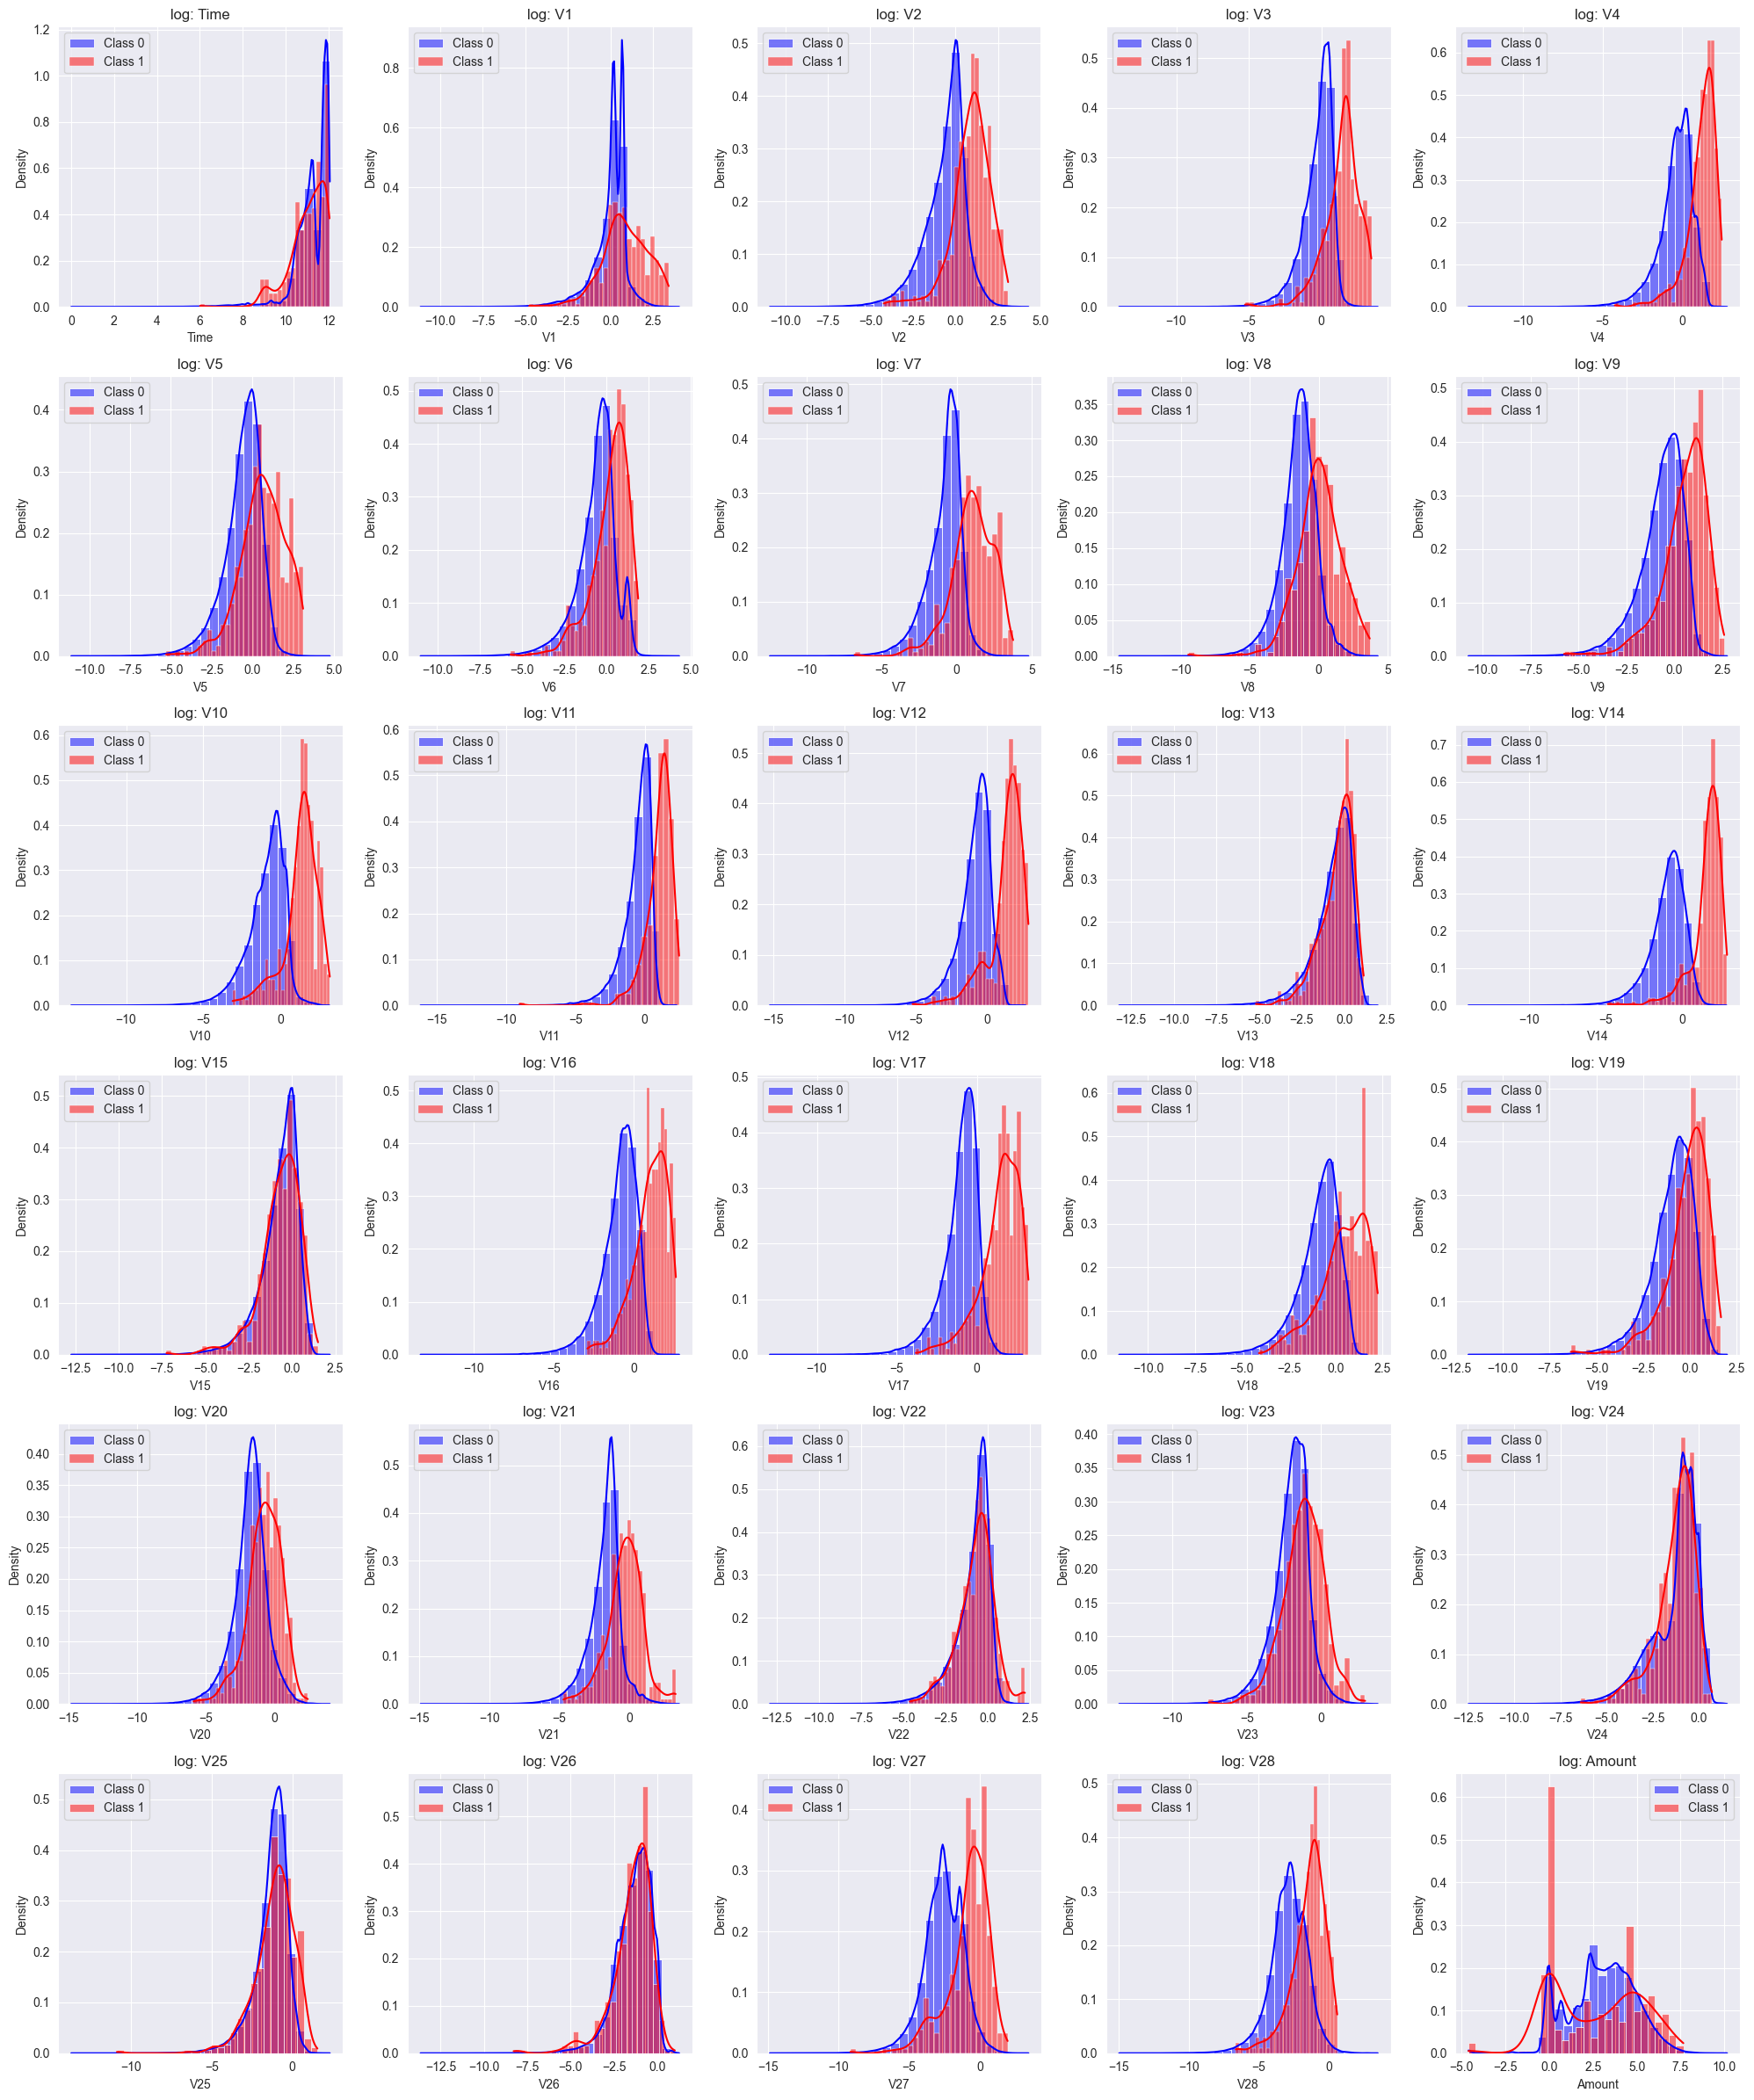

In [13]:
num_cols = df.select_dtypes(include=["number"]).columns

# surowka
train_df_raw = X_train_valid.copy()
train_df_raw['Class'] = y_train_valid


# log
train_df_log = X_train_valid.copy()
train_df_log = np.abs(train_df_log)
train_df_log = np.log1p(train_df_log)
train_df_log['Class'] = y_train_valid

# log nie 1p
train_df_log2 = X_train_valid.copy()
train_df_log2 = np.abs(train_df_log2)
train_df_log2 = np.log(train_df_log2)
train_df_log2['Class'] = y_train_valid

# piewsiatwkoswane
train_df_sqrt = X_train_valid.copy()
train_df_sqrt = np.abs(train_df_sqrt)
train_df_sqrt[num_cols] = np.sqrt(train_df_sqrt[num_cols])
train_df_sqrt['Class'] = y_train_valid



# Funkcja do tworzenia wykresów
def plot_histograms(train_df, title_prefix):
    num_columns = train_df.columns[:-1]  # Kolumny feature (bez Class)
    class_column = 'Class'

    fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 24))
    axes = axes.flatten()

    for i, col in enumerate(num_columns):
        ax = axes[i]
        # Histogram dla klasy 0
        sns.histplot(train_df[train_df[class_column] == 0][col], bins=30, kde=True, stat='density', color='blue', label='Class 0',
                     ax=ax, alpha=0.5)
        # Histogram dla klasy 1
        sns.histplot(train_df[train_df[class_column] == 1][col], bins=30, kde=True, stat='density', color='red', label='Class 1',
                     ax=ax, alpha=0.5)

        ax.set_title(f"{title_prefix}: {col}")
        ax.legend()

    # Wyłączenie pustych subplotów (mamy 29 cech, a siatka ma 30 miejsc)
    for i in range(len(num_columns), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

# wykresy
print("\n### Rozkład bez zmian ###")
plot_histograms(train_df_raw, "Bez zmian")

print("\n### Rozkład po logarytmowaniu1p ###")
plot_histograms(train_df_log, "Log1p")

print("\n### Rozkład po pierwiastkowaniu ###")
plot_histograms(train_df_sqrt, "Sqrt")

print("\n### Rozkład po logarytmowaniu ###")
plot_histograms(train_df_log2, "log")

Sprawdzimy jak usunięcie kolumn V15, V22, V26 wpływa na jakość naszego modelu, sprawdzimy również wpływ logarytmowania wartości 'Amount' na model

## Drugi punkt milestone2:

Tutaj mamy modelwoanie bazowe, budujemy pierwsze modele jako benchmark, oceniamy modele (bez balansowania) za pomocą metryk AUC-ROC oraz F1

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
import time


df = pd.read_csv("data/creditcard_csv.csv")
X = df.drop('Class', axis=1)
y = df['Class'].replace({"'0'": 0, "'1'": 1})
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train_valid_sqrt, X_test_sqrt, y_train_valid_sqrt, y_test_sqrt = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Przygotowanie danych (z dokumentu)
# Wersja 1: Bez pierwiastkowania V1-V28
X_train_valid['Amount'] = np.log1p(X_train_valid['Amount'])
X_test['Amount'] = np.log1p(X_test['Amount'])
X_train_valid = X_train_valid.drop('Time', axis=1)
X_test = X_test.drop('Time', axis=1)
# WYWALIC

# Wersja 2: Z pierwiastkowaniem V1-V28
X_train_valid_sqrt['Amount'] = np.log1p(X_train_valid_sqrt['Amount'])
X_test_sqrt['Amount'] = np.log1p(X_test_sqrt['Amount'])
v_columns = [f'V{i}' for i in range(1, 29)]
X_train_valid_sqrt[v_columns] = np.sqrt(np.abs(X_train_valid_sqrt[v_columns])) * np.sign(X_train_valid_sqrt[v_columns])
X_test_sqrt[v_columns] = np.sqrt(np.abs(X_test_sqrt[v_columns])) * np.sign(X_test_sqrt[v_columns])
X_train_valid_sqrt = X_train_valid_sqrt.drop('Time', axis=1)
X_test_sqrt = X_test_sqrt.drop('Time', axis=1)
# WYWALIC

# Lista modeli
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1)
}
# ZROBIC INACZEJ PIPELINE


def evaluate_model(model, X_train, X_test, y_train, y_test, data_type): # CHYBA DO WYJEBANIA
    print(f"Rozpoczynam trening: {type(model).__name__} na danych {data_type}")
    start_time = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    end_time = time.time()
    print(f"Zakończono: {type(model).__name__} na danych {data_type}, czas: {end_time - start_time:.2f} sekund")
    
    return {"Model": type(model).__name__, "Data": data_type, "AUC-ROC": auc_roc, "F1": f1}

# Wyniki
results = []

# Testowanie modeli na danych bez pierwiastkowania
for name, model in models.items():
    result = evaluate_model(model, X_train_valid, X_test, y_train_valid, y_test, "No Sqrt")
    results.append(result)

# Testowanie modeli na danych z pierwiastkowaniem
for name, model in models.items():
    result = evaluate_model(model, X_train_valid_sqrt, X_test_sqrt, y_train_valid_sqrt, y_test_sqrt, "Sqrt V1-V28")
    results.append(result)

# Tworzenie tabeli wyników
results_df = pd.DataFrame(results)
print(results_df)

# Opcjonalnie: zapis do pliku CSV
results_df.to_csv("model_comparison_results.csv", index=False)

C:\Users\Wojtek\AppData\Local\Temp\ipykernel_16880\2795006596.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Class'].replace({"'0'": 0, "'1'": 1})


Rozpoczynam trening: LogisticRegression na danych No Sqrt
Zakończono: LogisticRegression na danych No Sqrt, czas: 0.21 sekund
Rozpoczynam trening: DecisionTreeClassifier na danych No Sqrt
Zakończono: DecisionTreeClassifier na danych No Sqrt, czas: 14.77 sekund
Rozpoczynam trening: RandomForestClassifier na danych No Sqrt
Zakończono: RandomForestClassifier na danych No Sqrt, czas: 143.15 sekund
Rozpoczynam trening: LogisticRegression na danych Sqrt V1-V28
Zakończono: LogisticRegression na danych Sqrt V1-V28, czas: 0.18 sekund
Rozpoczynam trening: DecisionTreeClassifier na danych Sqrt V1-V28
Zakończono: DecisionTreeClassifier na danych Sqrt V1-V28, czas: 15.41 sekund
Rozpoczynam trening: RandomForestClassifier na danych Sqrt V1-V28
Zakończono: RandomForestClassifier na danych Sqrt V1-V28, czas: 140.41 sekund
                    Model         Data   AUC-ROC        F1
0      LogisticRegression      No Sqrt  0.944406  0.731343
1  DecisionTreeClassifier      No Sqrt  0.857932  0.746479
2  Ra

## wnioski: 

wsm to nie ma roznicy miedzy sqrt i niesqrt jezeli chodzi o te drzewiaste modele, mozna wsm dorobic accuracy zeby jeszcze sprawdzic, jeszcze nie wiem co te liczby znacza bo malysz siedzi po mojej prawicy dlatego nie chce wchodzic do czata gpt ale to sie ogarnie 

Poniżej kod jedzący procesor

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
import time


df = pd.read_csv("data/creditcard_csv.csv")
X = df.drop('Class', axis=1)
y = df['Class'].replace({"'0'": 0, "'1'": 1})
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train_valid_sqrt, X_test_sqrt, y_train_valid_sqrt, y_test_sqrt = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Przygotowanie danych (z dokumentu)
# Wersja 1: Bez pierwiastkowania V1-V28
X_train_valid['Amount'] = np.log1p(X_train_valid['Amount'])
X_test['Amount'] = np.log1p(X_test['Amount'])
X_train_valid = X_train_valid.drop('Time', axis=1)
X_test = X_test.drop('Time', axis=1)

# Wersja 2: Z pierwiastkowaniem V1-V28
X_train_valid_sqrt['Amount'] = np.log1p(X_train_valid_sqrt['Amount'])
X_test_sqrt['Amount'] = np.log1p(X_test_sqrt['Amount'])
v_columns = [f'V{i}' for i in range(1, 29)]
X_train_valid_sqrt[v_columns] = np.sqrt(np.abs(X_train_valid_sqrt[v_columns])) * np.sign(X_train_valid_sqrt[v_columns])
X_test_sqrt[v_columns] = np.sqrt(np.abs(X_test_sqrt[v_columns])) * np.sign(X_test_sqrt[v_columns])
X_train_valid_sqrt = X_train_valid_sqrt.drop('Time', axis=1)
X_test_sqrt = X_test_sqrt.drop('Time', axis=1)

# Lista modeli
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1)
}


def evaluate_model(model, X_train, X_test, y_train, y_test, data_type):
    print(f"Rozpoczynam trening: {type(model).__name__} na danych {data_type}")
    start_time = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc_roc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    end_time = time.time()
    print(f"Zakończono: {type(model).__name__} na danych {data_type}, czas: {end_time - start_time:.2f} sekund")

    return {"Model": type(model).__name__, "Data": data_type, "AUC-ROC": auc_roc, "F1": f1}

# Wyniki
results = []

# Testowanie modeli na danych bez pierwiastkowania
for name, model in models.items():
    result = evaluate_model(model, X_train_valid, X_test, y_train_valid, y_test, "No Sqrt")
    results.append(result)

# Testowanie modeli na danych z pierwiastkowaniem
for name, model in models.items():
    result = evaluate_model(model, X_train_valid_sqrt, X_test_sqrt, y_train_valid_sqrt, y_test_sqrt, "Sqrt V1-V28")
    results.append(result)

# Tworzenie tabeli wyników
results_df = pd.DataFrame(results)
print(results_df)

# Opcjonalnie: zapis do pliku CSV
results_df.to_csv("model_comparison_results.csv", index=False)

C:\Users\Wojtek\AppData\Local\Temp\ipykernel_16880\376693443.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Class'].replace({"'0'": 0, "'1'": 1})


Rozpoczynam trening: LogisticRegression na danych No Sqrt
Zakończono: LogisticRegression na danych No Sqrt, czas: 0.20 sekund
Rozpoczynam trening: DecisionTreeClassifier na danych No Sqrt
Zakończono: DecisionTreeClassifier na danych No Sqrt, czas: 14.59 sekund
Rozpoczynam trening: RandomForestClassifier na danych No Sqrt
Zakończono: RandomForestClassifier na danych No Sqrt, czas: 15.69 sekund
Rozpoczynam trening: LogisticRegression na danych Sqrt V1-V28
Zakończono: LogisticRegression na danych Sqrt V1-V28, czas: 0.16 sekund
Rozpoczynam trening: DecisionTreeClassifier na danych Sqrt V1-V28
Zakończono: DecisionTreeClassifier na danych Sqrt V1-V28, czas: 15.90 sekund
Rozpoczynam trening: RandomForestClassifier na danych Sqrt V1-V28
Zakończono: RandomForestClassifier na danych Sqrt V1-V28, czas: 15.06 sekund
                    Model         Data   AUC-ROC        F1
0      LogisticRegression      No Sqrt  0.944406  0.731343
1  DecisionTreeClassifier      No Sqrt  0.857932  0.746479
2  Rand

Sprawdzimy/
log na kolumnach v/
log na amount/
wyjebanie kolumn/

dla modeli: /
logreg/
drzewadec/
lasy losowe/
svm/

# SVM

In [69]:
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, amount_log=False):
        self.amount_log = amount_log

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X = X.copy()
        if 'Time' in X.columns:
            X.drop('Time', axis=1, inplace=True)
        if self.amount_log and 'Amount' in X.columns:
            X['Amount'] = np.log1p(X['Amount'])
        return X

class CustomVarianceThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.0):
        self.threshold = threshold
        self.features_to_keep_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        self.features_to_keep_ = [col for col in X.columns if col not in ['Time', 'Amount'] and X[col].var() >= self.threshold]
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X = X.copy()
        return X[self.features_to_keep_ + ['Time', 'Amount']]

svm_clf = Pipeline([
    ('var', CustomVarianceThreshold()),
    ('custom_transformer', CombinedTransformer()),
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='poly')),
])

# svm_clf.fit(X_train_valid, y_train_valid)
#
# y_pred = svm_clf.predict(X_test)
#
# auc_roc = roc_auc_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
#
# print("AUC-ROC: ", auc_roc, "F1-SCORE: ", f1)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Na te SVM jest potencjał, ale jest też wiele problemów. Załatwia kwestię co zrobić z kolumnami po PCA, bo trzeba skalować. Wielki plus jest taki, że te SVM jest o wiele bardziej wyjaśnialne niż lasy losowe

In [70]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'classifier__C':[0.1, 1], 'custom_transformer__amount_log':[True, False], 'var__threshold': [0, 0.5, 1, 1.5]}]

grid_search = GridSearchCV(svm_clf, param_grid, cv=3, scoring='f1', return_train_score=True)

grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('var', CustomVarianceThreshold()),
                                       ('custom_transformer',
                                        CombinedTransformer()),
                                       ('scaler', StandardScaler()),
                                       ('classifier', SVC(kernel='poly'))]),
             param_grid=[{'classifier__C': [0.1, 1],
                          'custom_transformer__amount_log': [True, False],
                          'var__threshold': [0, 0.5, 1, 1.5]}],
             return_train_score=True, scoring='f1')

In [71]:
grid_search.best_params_

{'classifier__C': 0.1,
 'custom_transformer__amount_log': False,
 'var__threshold': 0}

In [72]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.8240599826982411 {'classifier__C': 0.1, 'custom_transformer__amount_log': True, 'var__threshold': 0}
0.8127551883482926 {'classifier__C': 0.1, 'custom_transformer__amount_log': True, 'var__threshold': 0.5}
0.7466551510486097 {'classifier__C': 0.1, 'custom_transformer__amount_log': True, 'var__threshold': 1}
0.6309152289544446 {'classifier__C': 0.1, 'custom_transformer__amount_log': True, 'var__threshold': 1.5}
0.8258230426905127 {'classifier__C': 0.1, 'custom_transformer__amount_log': False, 'var__threshold': 0}
0.8068307429490185 {'classifier__C': 0.1, 'custom_transformer__amount_log': False, 'var__threshold': 0.5}
0.7348867385904424 {'classifier__C': 0.1, 'custom_transformer__amount_log': False, 'var__threshold': 1}
0.6141661849597697 {'classifier__C': 0.1, 'custom_transformer__amount_log': False, 'var__threshold': 1.5}
0.8132706684957686 {'classifier__C': 1, 'custom_transformer__amount_log': True, 'var__threshold': 0}
0.8065719524217547 {'classifier__C': 1, 'custom_transformer__am

In [74]:
import joblib

joblib.dump(grid_search.best_estimator_, 'best_SVM.pkl')

# wczytac
# best_SVM = joblib.load('best_SVM.pkl')

['best_SVM.pkl']

In [75]:
best_SVM = joblib.load('best_SVM.pkl')

In [79]:
y_pred = best_SVM.predict(X_train_valid)
f1_score(y_train_valid, y_pred)

0.8970013037809648

In [81]:
roc_auc_score(y_train_valid, y_pred)

0.9114729087751993

Potencjał jest, ale myślę że wejdziemy w lasy losowe

In [5]:
import numpy as np

np.log1p(-3)

C:\Users\Wojtek\AppData\Local\Temp\ipykernel_18704\2140858783.py:3: RuntimeWarning: invalid value encountered in log1p
  np.log1p(-3)


np.float64(nan)